In [1]:
import sys

import torch  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import pytorch_lightning as pl  # noqa: E402
import matplotlib.pyplot as plt

from pydil.utils.Online_GMM import Online_GMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

import importlib

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = np.load(r'C:\Users\SL276123\Documents\Online DaDiL\CSTR\data\cstr_acfmeandata.npy')

In [3]:
dataset.shape

(2860, 18)

In [4]:
X = dataset[:, :-4]
y = dataset[:, -4]
d = dataset[:, -3]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [5]:
X.shape, y.shape, d.shape

((2860, 14), (2860,), (2860,))

In [6]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [7]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [8]:
n_samples = 1300
batch_size = 260
n_components = 3

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==6)[0], :], y[np.where(d==6)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)
dim_reduction = 11

In [10]:
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

dim_reduction = 3
K_max = 13
OGMM = Online_GMM(
    n_components=K_max, 
    lr=0.1,
    n_features=dim_reduction,
    data_range=range_data,
    batch_size=batch_size
)

i=0
while i < Xt.shape[0]-dim_reduction:
    OGMM.fit_sample(Xt[i:i+dim_reduction, :], dimension_reduction=True)
    i += dim_reduction

OGMM.generate_list()

c:\Users\SL276123\Documents\Online DaDiL\PyDiL-main\PyDiL-main\pydil\utils\Online_GMM.py:89: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  return (2*np.pi)**(-len(x)/2) * np.linalg.det(cov)**(-1/2) * np.exp(-1/2 * (x - mean).T @ np.linalg.inv(cov) @ (x - mean))


[[tensor(3.7446e-06),
  tensor(23.5341),
  tensor([ 0.2566, -0.0072,  0.0018]),
  tensor([[ 8.7732e-04, -8.1179e-06, -4.3610e-05],
          [-8.1179e-06,  1.6886e-04,  1.0428e-04],
          [-4.3610e-05,  1.0428e-04,  4.0313e-04]])],
 [tensor(8.4565e-11),
  tensor(18.0840),
  tensor([-0.3460, -0.0053,  0.0118]),
  tensor([[ 0.0042,  0.0004, -0.0010],
          [ 0.0004,  0.0013,  0.0002],
          [-0.0010,  0.0002,  0.0014]])],
 [tensor(9.6604e-08),
  tensor(6.9066),
  tensor([-0.5394,  0.4402,  0.0554]),
  tensor([[ 0.0214,  0.0068, -0.0184],
          [ 0.0068,  0.0124,  0.0016],
          [-0.0184,  0.0016,  0.0283]])],
 [tensor(0.0001),
  tensor(11.3709),
  tensor([0.1283, 0.5368, 0.0433]),
  tensor([[0.0109, 0.0077, 0.0068],
          [0.0077, 0.0169, 0.0182],
          [0.0068, 0.0182, 0.0217]])],
 [tensor(6.7955e-07),
  tensor(3.4565),
  tensor([ 0.0818, -0.4050,  0.5018]),
  tensor([[ 0.0039, -0.0060,  0.0122],
          [-0.0060,  0.0280, -0.0521],
          [ 0.0122, -0.0

## Tests on the GMM

In [11]:
np.sum(OGMM.score_samples(Xt, dimension_reduction=True))

-22.95161497907543

In [12]:
sklearn_GMM = GaussianMixture(n_components=K_max, random_state=0)
sklearn_GMM.fit(Xt)
np.sum(sklearn_GMM.score_samples(Xt))

14216.687280789334

(0.0, 1.0, 0.0, 1.0)

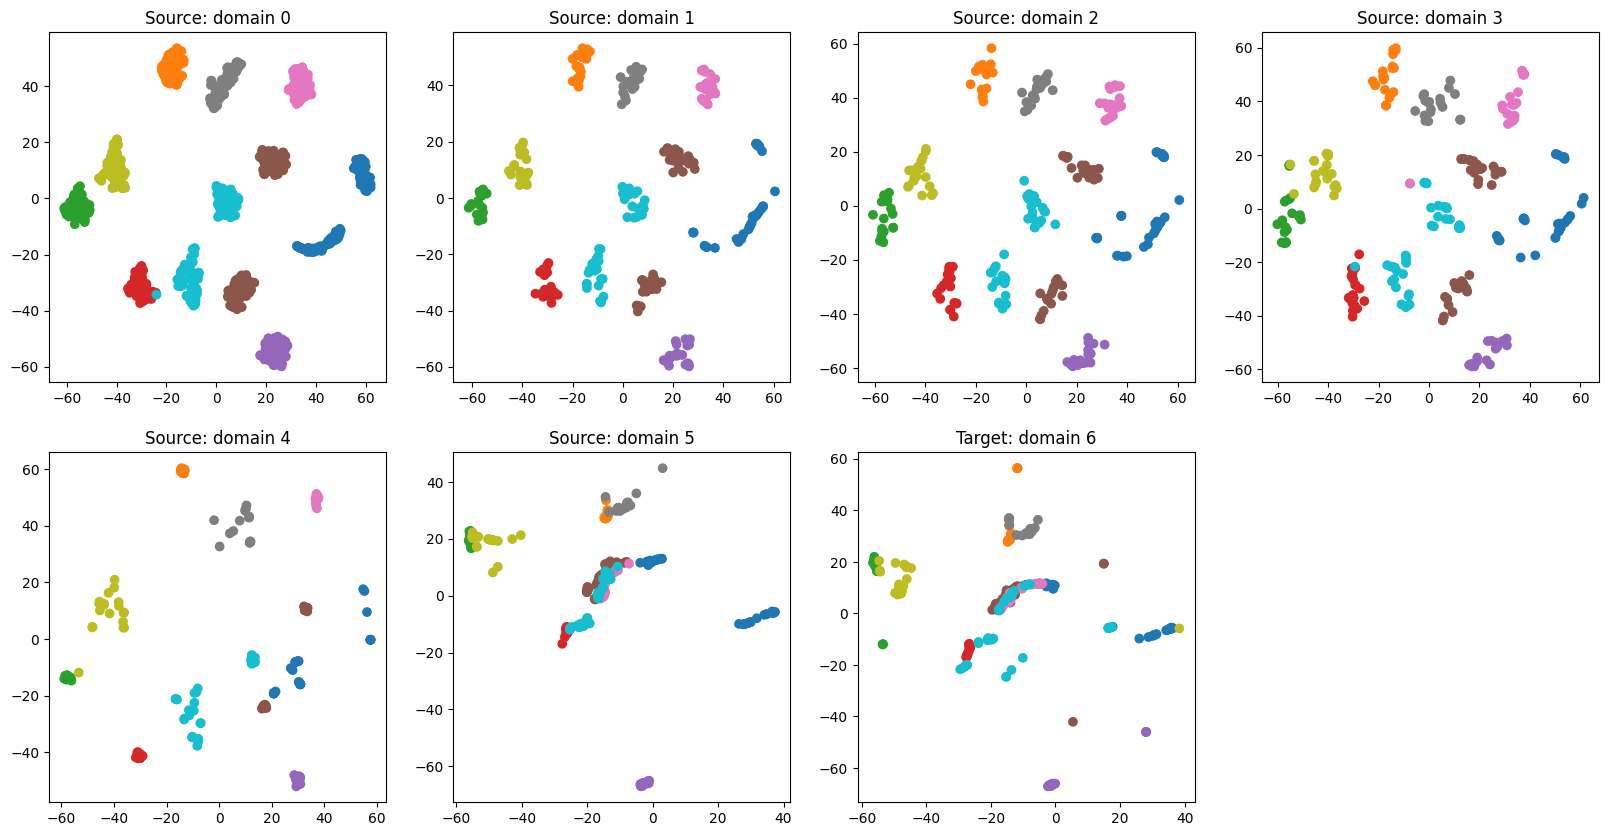

In [13]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [Xt], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys + [yt], dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
        
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

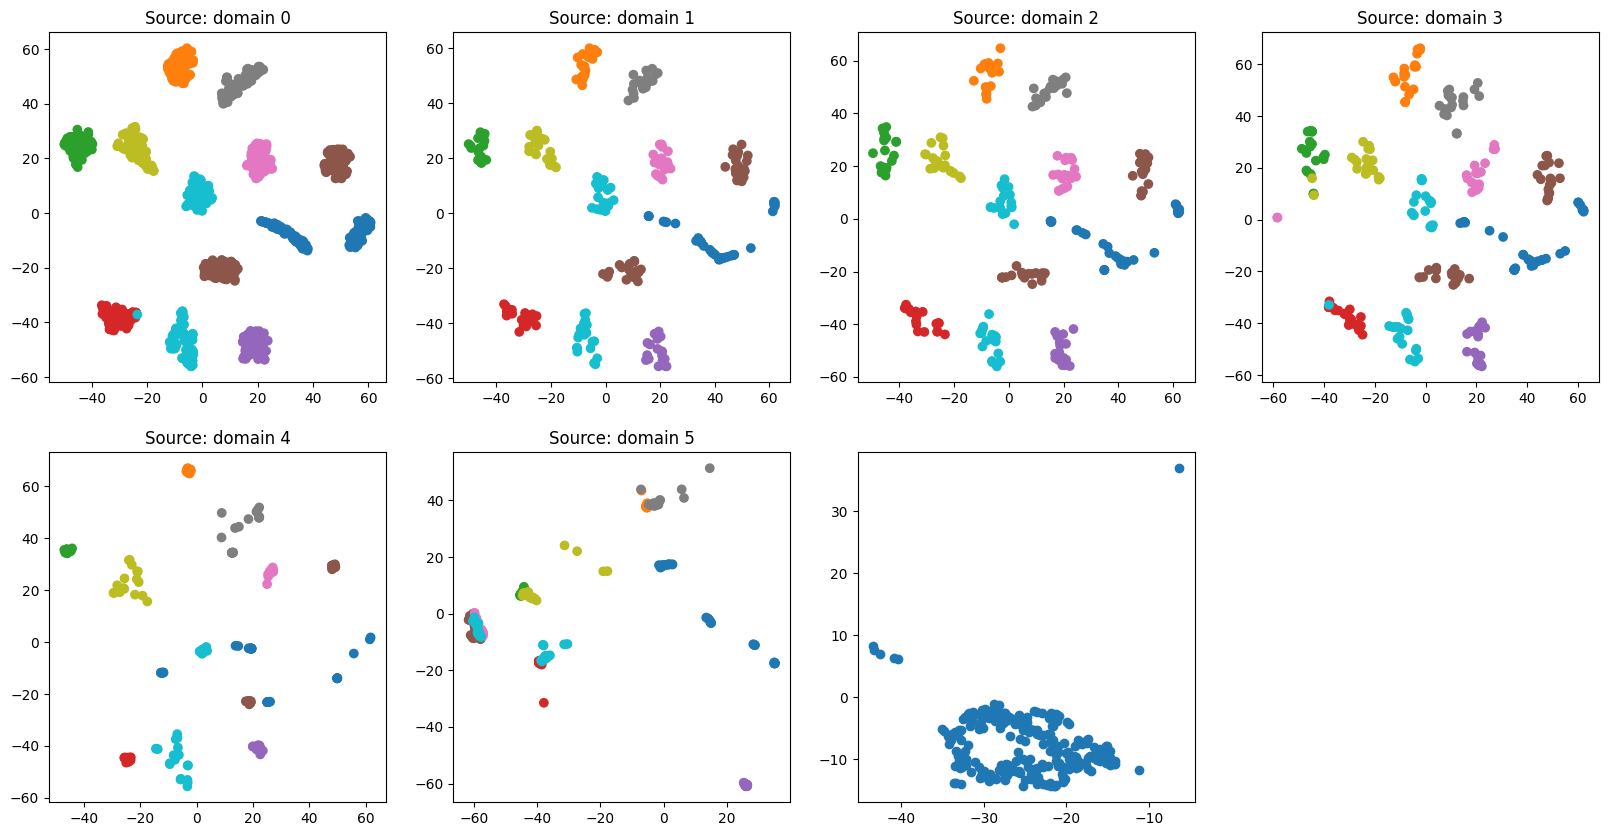

In [14]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [OGMM.sample(260)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-2]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == 6)[0]
axes.flatten()[-2].scatter(proj[ind, 0],
               proj[ind, 1])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

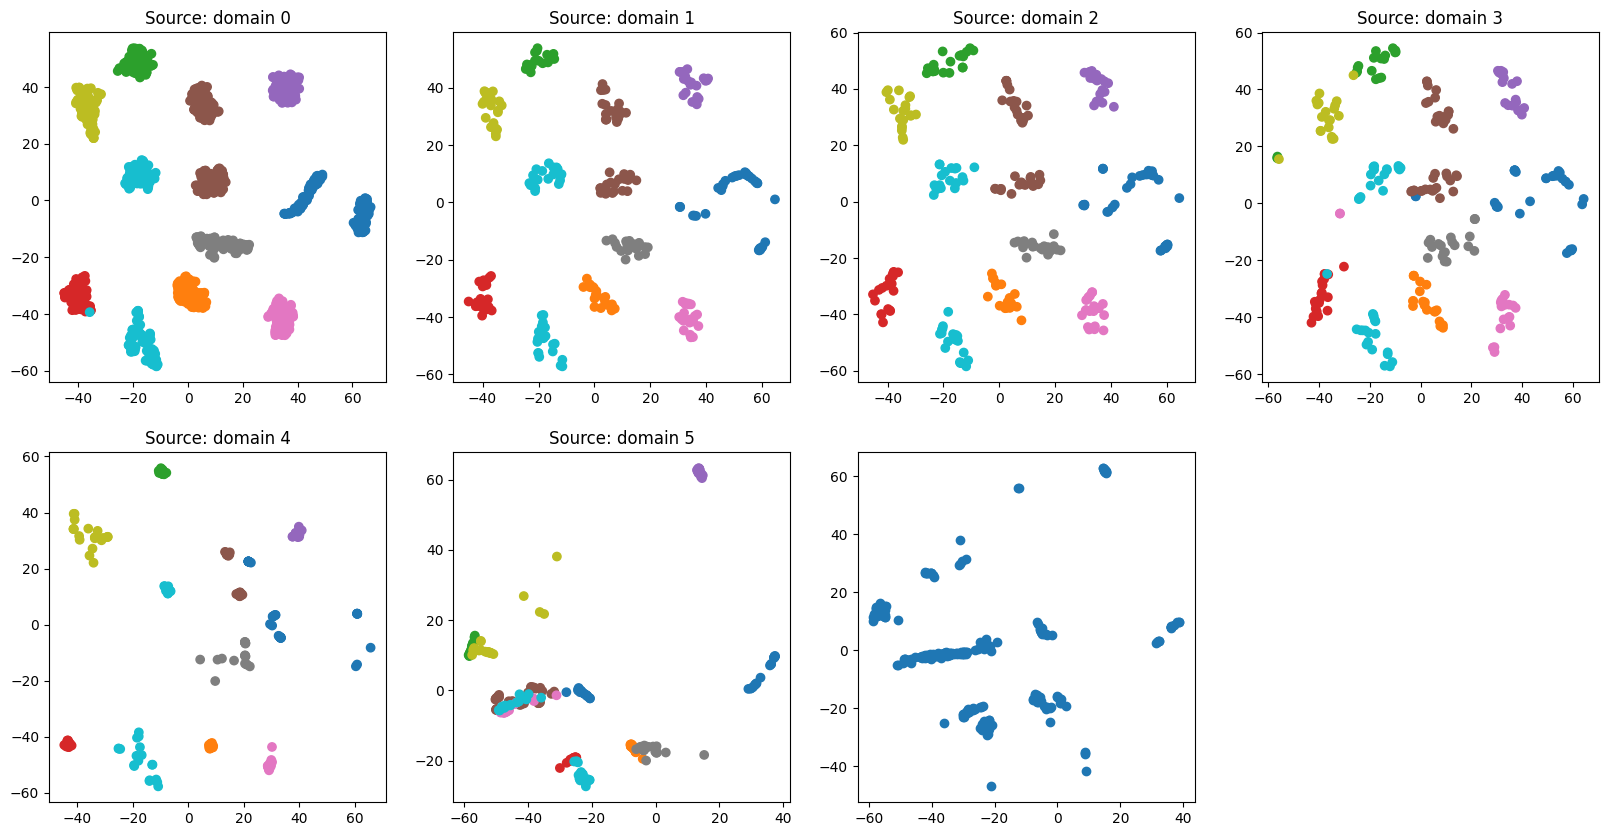

In [15]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [torch.from_numpy(sklearn_GMM.sample(260)[0]).float()], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-2]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == 6)[0]
axes.flatten()[-2].scatter(proj[ind, 0],
               proj[ind, 1])
axes.flatten()[-1].axis('off')

Test to determine the best K_max

In [16]:
%%script false --no-exec
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

K_max = np.linspace(13, 63, 11)
ll = []
for kmax in K_max:
    OGMM = Online_GMM(
        n_components=kmax, 
        lr=0.1,
        n_features=dim_reduction,
        data_range=range_data,
        batch_size=batch_size
    )
    
    i = 0
    while i < X_train_target_t.shape[0]-dim_reduction:
        OGMM.fit_sample(X_train_target_t[i:i+dim_reduction, :], dimension_reduction=True)
        i += dim_reduction

    print(OGMM.generate_list())
    ll.append(OGMM.log_likelihood(X_test_target_t, dimension_reduction=True))

Couldn't find program: 'false'


## Dictionary learning seperated between sources and target with Online_GMM simultaneously

In [17]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )

In [18]:
criterion = JointWassersteinDistance()

In [19]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [20]:
dictionary_sources.fit(Q_sources,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/40, Loss: 105.93146057128905
It 2/40, Loss: 47.146636199951175
It 3/40, Loss: 20.49601573944092
It 4/40, Loss: 9.168063640594482
It 5/40, Loss: 4.755572652816772
It 6/40, Loss: 2.7495007514953618
It 7/40, Loss: 1.843884325027466
It 8/40, Loss: 1.371592378616333
It 9/40, Loss: 1.0683929443359375
It 10/40, Loss: 0.845786714553833
It 11/40, Loss: 0.726038134098053
It 12/40, Loss: 0.6322850465774537
It 13/40, Loss: 0.5842637062072754
It 14/40, Loss: 0.5344431519508361
It 15/40, Loss: 0.5199695587158203
It 16/40, Loss: 0.49566559791564935
It 17/40, Loss: 0.49219954013824463
It 18/40, Loss: 0.47139850854873655
It 19/40, Loss: 0.4572354495525361
It 20/40, Loss: 0.4260922849178314
It 21/40, Loss: 0.40813576579093935
It 22/40, Loss: 0.37302801609039304
It 23/40, Loss: 0.3346874356269836
It 24/40, Loss: 0.2965018808841705
It 25/40, Loss: 0.25150881707668304
It 26/40, Loss: 0.22598537504673005
It 27/40, Loss: 0.2148199379444122
It 28/40, Loss: 0.20395381450653075
It 29/40, Loss: 0.1953358739

In [21]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [22]:
names_sources = [f'domain {i}' for i in range(6)]

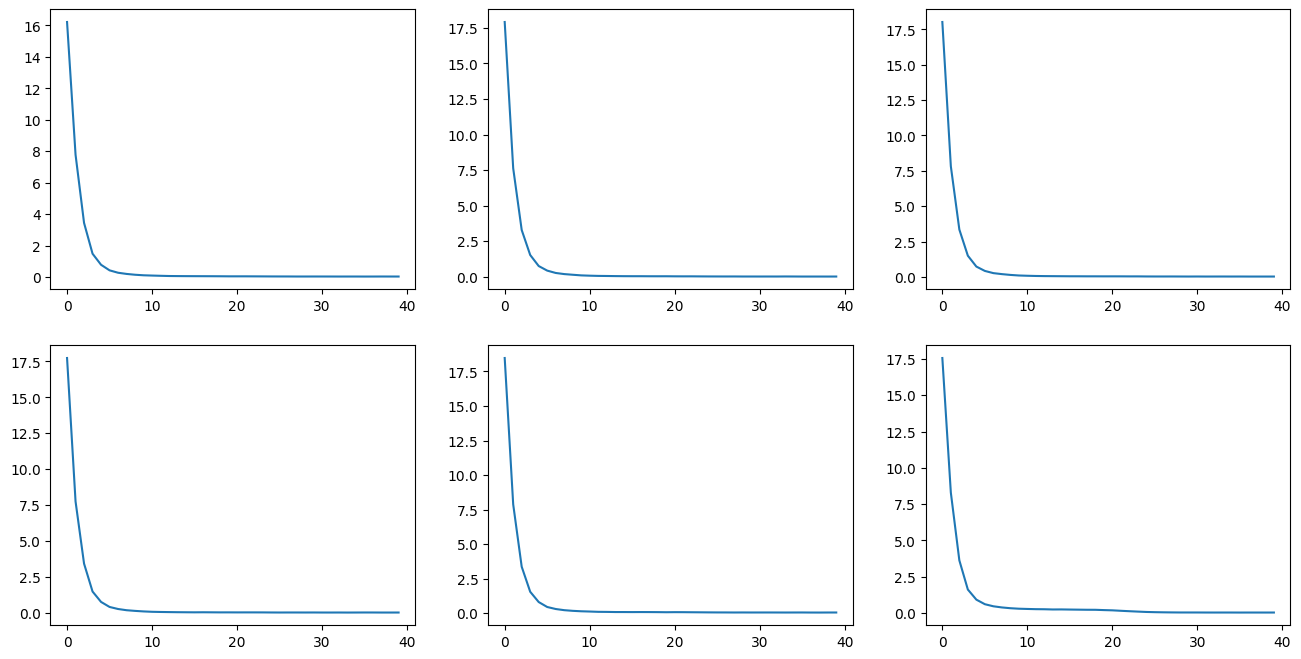

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

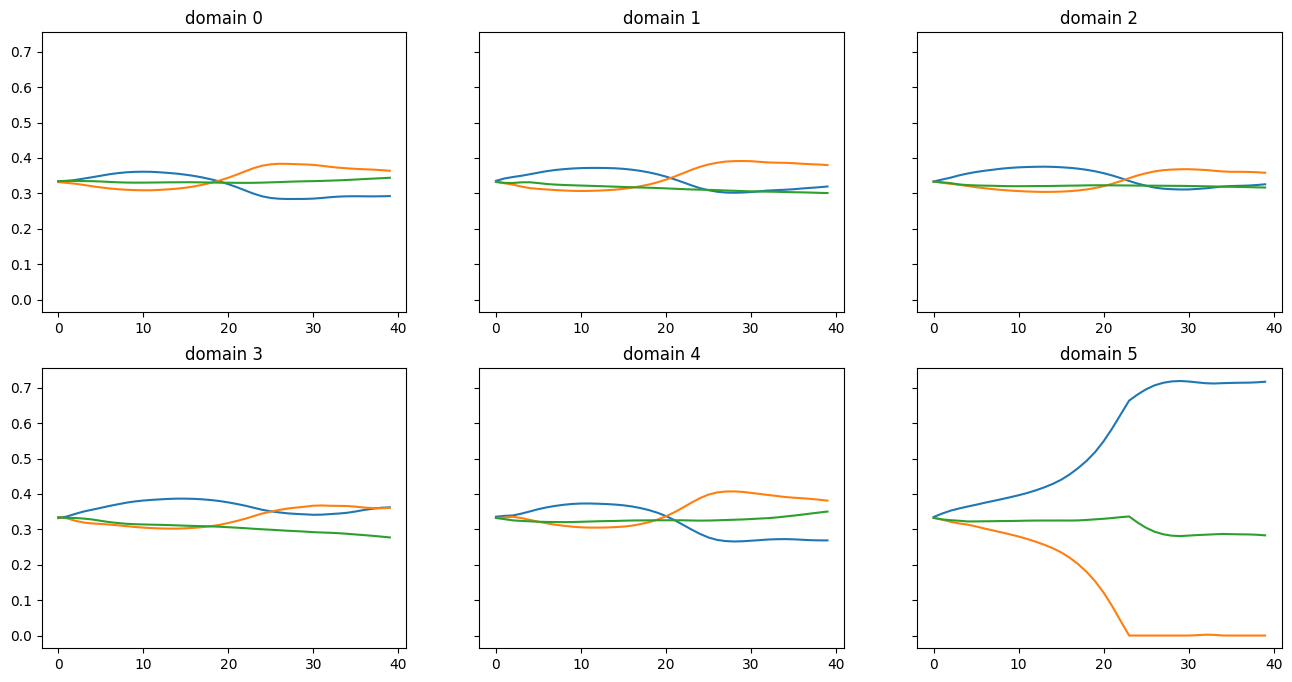

In [24]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten())):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [25]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=1,
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False,
                           GMM_components=13,
                           GMM_dim_reduction=dim_reduction)

In [26]:
i = 0
while i < Xt.shape[0]-dim_reduction:
    print(i)
    dictionary_target.fit_target_sample(Xt[i:i+dim_reduction, :],
                                        batches_per_it=n_samples // batch_size,
                                        batch_size=batch_size,
                                        verbose=True,
                                        regularization=False,)
    i += dim_reduction

0
Loss: 0.5558950185775756
3
Loss: 0.5498772740364075
6
Loss: 0.5034364223480224
9
Loss: 0.5037954032421113
12
Loss: 0.4640149295330047
15
Loss: 0.4329355001449585
18
Loss: 0.4172757089138031
21
Loss: 0.31249067187309265
24
Loss: 0.2623829007148743
27
Loss: 0.24384657740592955
30
Loss: 0.2319453328847885
33
Loss: 0.23513312339782713
36
Loss: 0.2394973337650299
39
Loss: 0.20865599811077118
42
Loss: 0.2578182280063629
45
Loss: 0.3631216585636139
48
Loss: 0.4754300355911255
51
Loss: 0.38144676685333256
54
Loss: 0.43138325214385986
57
Loss: 0.46406247019767766
60
Loss: 0.31437627077102664
63
Loss: 0.3020647048950195
66
Loss: 0.3910017549991608
69
Loss: 0.3509104549884796
72
Loss: 0.3818154394626617
75
Loss: 0.39691269397735596
78
Loss: 0.35778198838233943
81
Loss: 0.2424074739217758
84
Loss: 0.2587161242961884
87
Loss: 0.25938960313797
90
Loss: 0.267213773727417
93
Loss: 0.2962449729442596
96
Loss: 0.34170768260955814
99
Loss: 0.2893910646438599
102
Loss: 0.23180729150772092
105
Loss: 0.20

In [27]:
target_name = 'Domain 7'

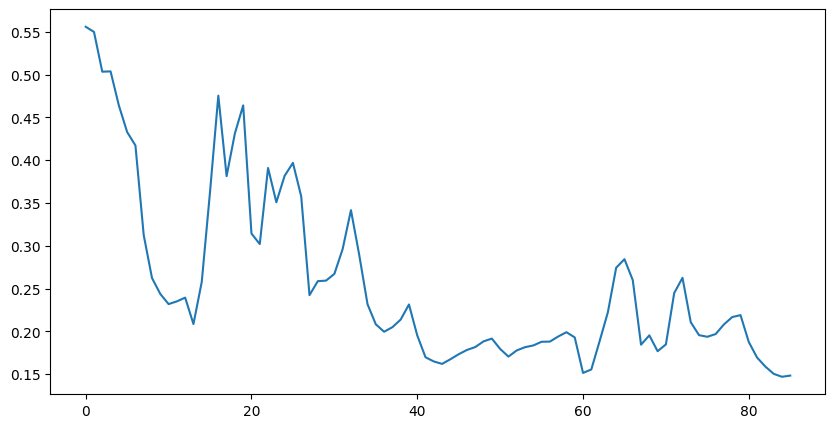

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

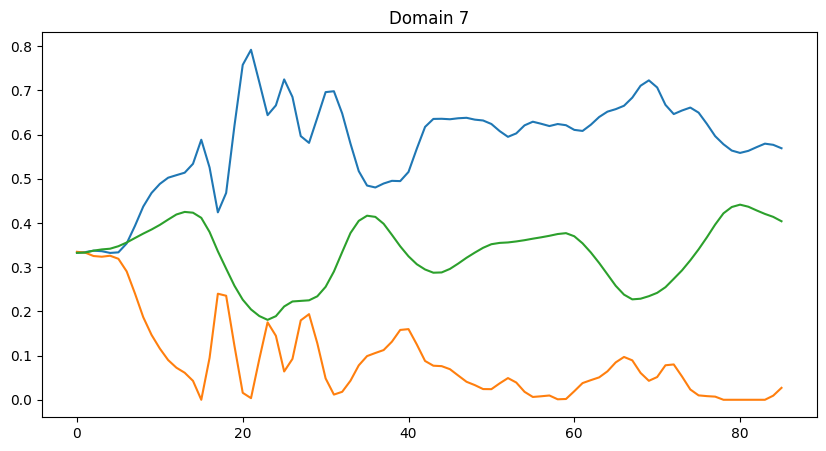

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, 0, :])
ax.set_title(target_name)

(0.0, 1.0, 0.0, 1.0)

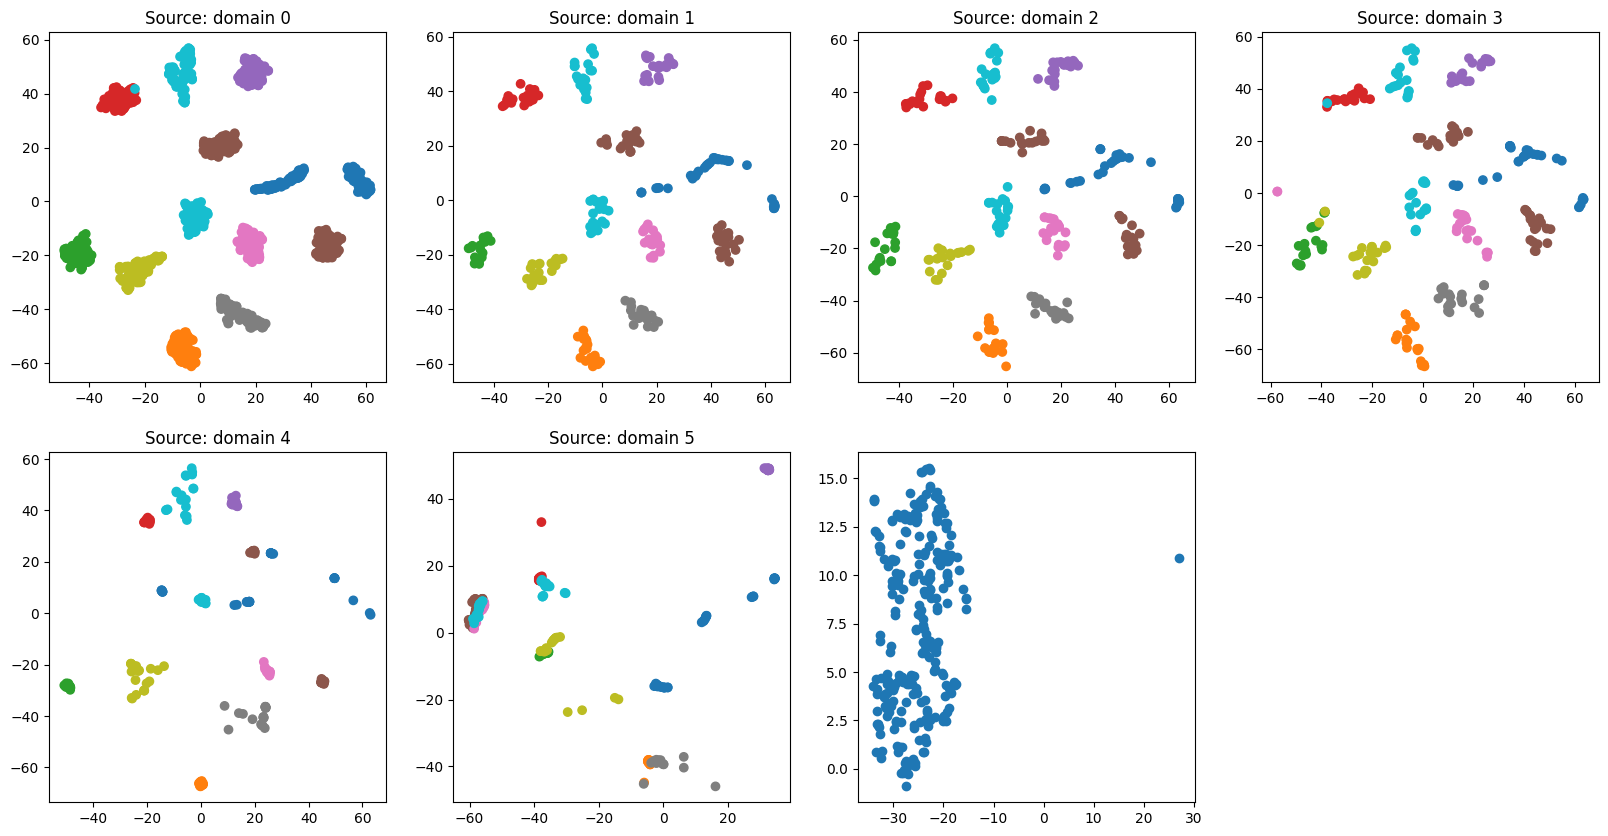

In [30]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [dictionary_target.OGMM.sample(260)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-2]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == 6)[0]
axes.flatten()[-2].scatter(proj[ind, 0],
               proj[ind, 1])
axes.flatten()[-1].axis('off')

In [31]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.5691, 0.0270, 0.4039])


In [ ]:
Xr, Yr = dictionary_target.reconstruct(weights=weights)

In [33]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

In [53]:
Xt_OGMM = dictionary_target.OGMM.sample(1300)[0]

In [54]:
C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2

In [57]:
import ot

In [61]:
ot_plan = ot.emd(torch.ones(Xr.shape[0])/Xr.shape[0], torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0], C, numItermax=1000000)

In [67]:
ot_plan[0, 590]

tensor(0.0008)

In [74]:
1/1300

0.0007692307692307692

In [73]:
torch.sum(ot_plan[:, 3])

tensor(0.0008)

In [66]:
np.where(ot_plan[0]!=0)

(array([590], dtype=int64),)

Classification without DA

In [34]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.85


DaDiL-E

In [45]:
clf = SVC(kernel='rbf', probability=True)
#clf = RandomForestClassifier(criterion='gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.5690000057220459 got 0.6307692307692307
Atom 1 w/ weight 0.027000000700354576 got 0.2
Atom 2 w/ weight 0.40400001406669617 got 0.4807692307692308
0.6653846153846154


DaDiL-R

In [42]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.6730769230769231


## Dictionary learning seperated between sources and target

In [11]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q_target = [OGMM]

Q_sources_and_target = Q_sources + Q_target

In [12]:
criterion = JointWassersteinDistance()

In [13]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [14]:
dictionary_sources.fit(Q_sources,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/40, Loss: 104.57844085693358
It 2/40, Loss: 47.296287536621094
It 3/40, Loss: 21.1998779296875
It 4/40, Loss: 9.636614513397218
It 5/40, Loss: 4.858103561401367
It 6/40, Loss: 2.7757709980010983
It 7/40, Loss: 1.8640250205993651
It 8/40, Loss: 1.3968632698059082
It 9/40, Loss: 1.0574773669242858
It 10/40, Loss: 0.8586440920829773
It 11/40, Loss: 0.7276647210121155
It 12/40, Loss: 0.6436547875404358
It 13/40, Loss: 0.5781718254089355
It 14/40, Loss: 0.5403692960739136
It 15/40, Loss: 0.516750556230545
It 16/40, Loss: 0.5063962161540985
It 17/40, Loss: 0.48693756461143495
It 18/40, Loss: 0.4822140634059906
It 19/40, Loss: 0.4801057100296021
It 20/40, Loss: 0.47911582589149476
It 21/40, Loss: 0.45885319709777833
It 22/40, Loss: 0.4519703805446625
It 23/40, Loss: 0.4371341347694397
It 24/40, Loss: 0.41318297386169434
It 25/40, Loss: 0.392229038476944
It 26/40, Loss: 0.35999270081520085
It 27/40, Loss: 0.3272894501686096
It 28/40, Loss: 0.2829329431056976
It 29/40, Loss: 0.235739430785

In [15]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [16]:
names_sources = [f'domain {i}' for i in range(6)]

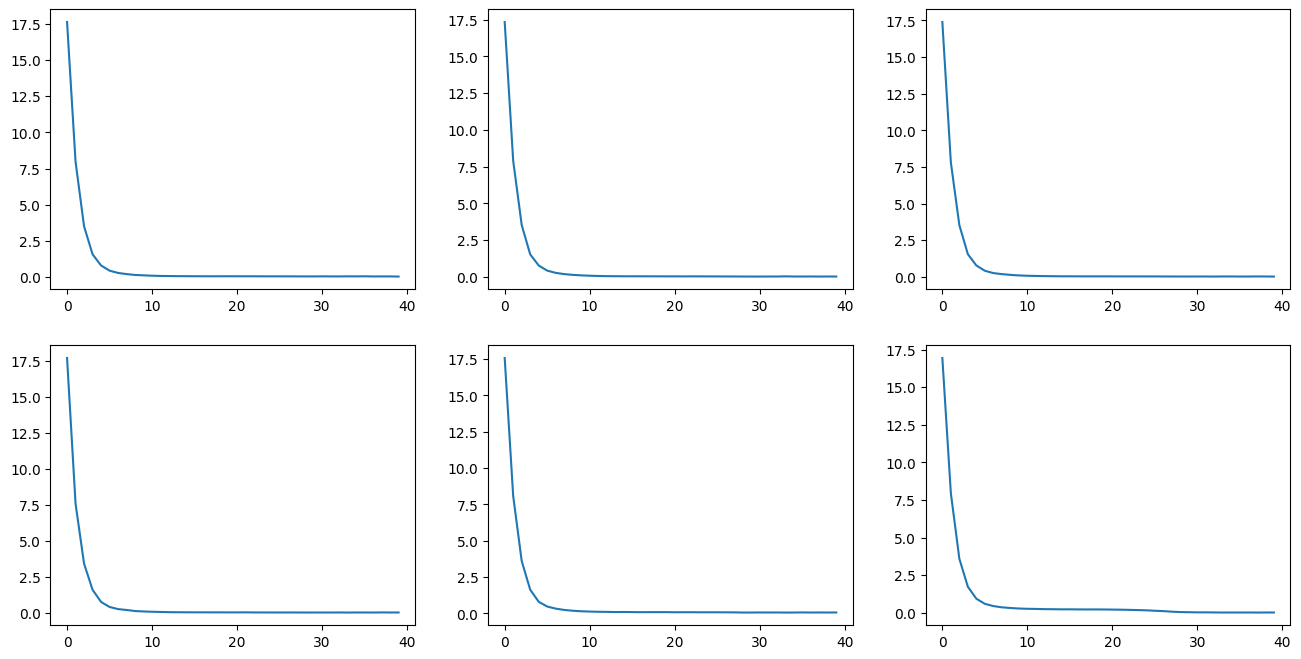

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

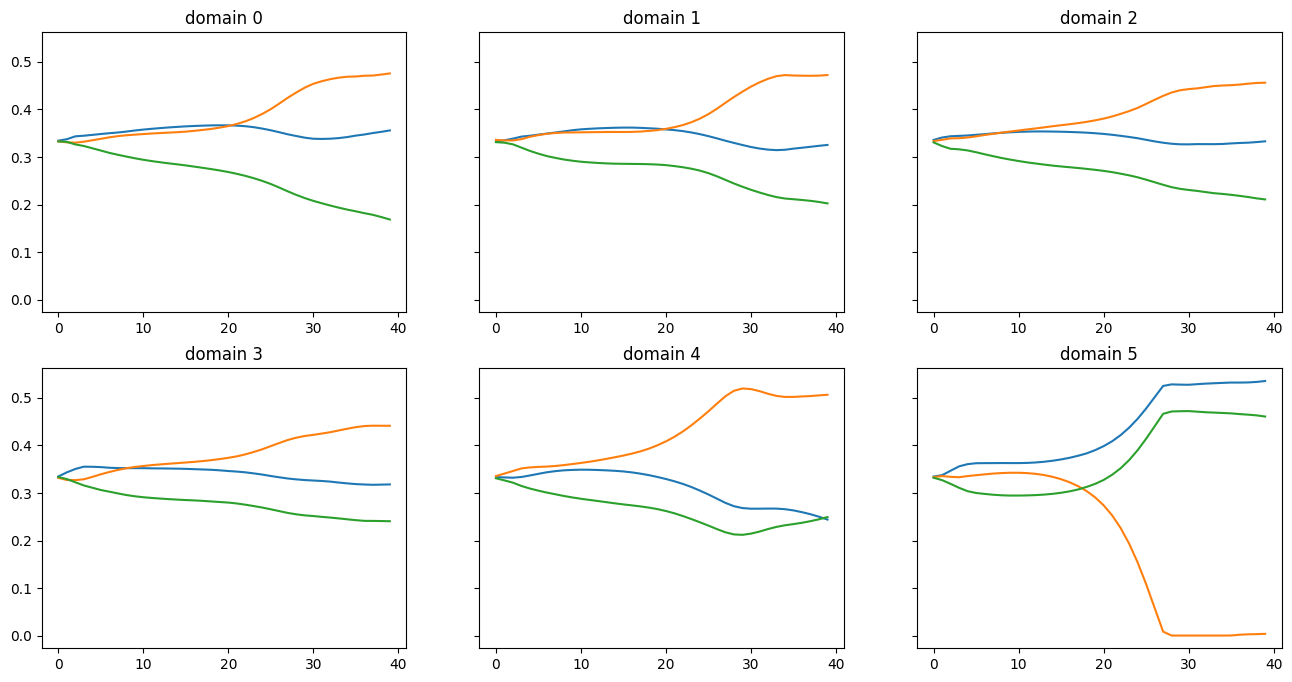

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten())):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [19]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources_and_target),
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [20]:
dictionary_target.fit(Q_sources_and_target,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               regularization=False)

It 1/40, Loss: 0.541308319568634
It 2/40, Loss: 0.4893208980560303
It 3/40, Loss: 0.4773732244968414
It 4/40, Loss: 0.4586874544620514
It 5/40, Loss: 0.4618903756141663
It 6/40, Loss: 0.47010503411293036
It 7/40, Loss: 0.4841661512851715
It 8/40, Loss: 0.46967995166778564
It 9/40, Loss: 0.4633421957492828
It 10/40, Loss: 0.4575952291488648
It 11/40, Loss: 0.47299667000770573
It 12/40, Loss: 0.46858082413673396
It 13/40, Loss: 0.46630826592445374
It 14/40, Loss: 0.4711249947547913
It 15/40, Loss: 0.46509169936180117
It 16/40, Loss: 0.46258374452590945
It 17/40, Loss: 0.4583864986896515
It 18/40, Loss: 0.46396523118019106
It 19/40, Loss: 0.46802442073822026
It 20/40, Loss: 0.4755739033222198
It 21/40, Loss: 0.47952997684478754
It 22/40, Loss: 0.4671863496303559
It 23/40, Loss: 0.4725158810615539
It 24/40, Loss: 0.46633942127227784
It 25/40, Loss: 0.46509851813316344
It 26/40, Loss: 0.4702645063400269
It 27/40, Loss: 0.47358508706092833
It 28/40, Loss: 0.4653015077114105
It 29/40, Loss: 0

In [21]:
target_name = 'Domain 7'

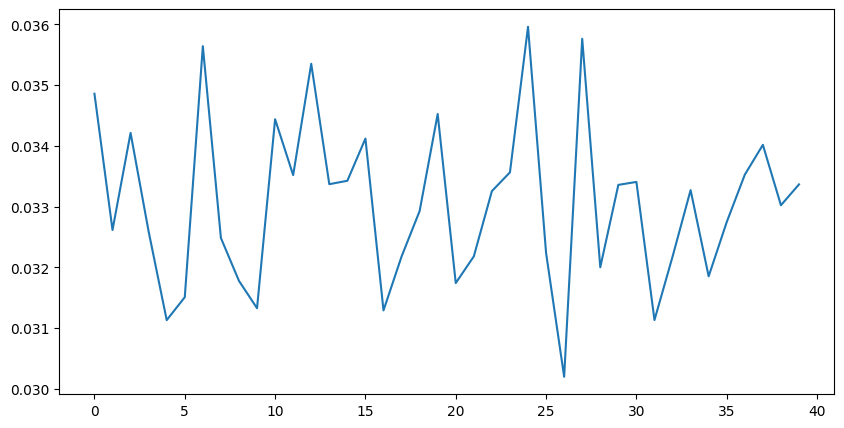

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

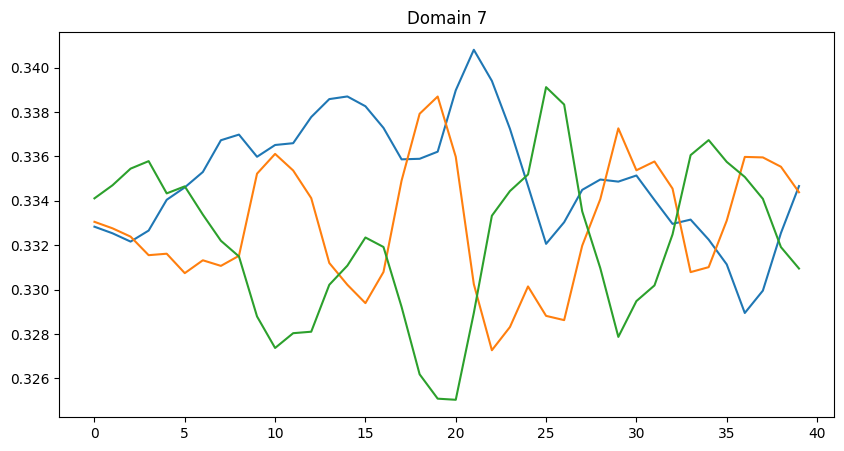

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

In [24]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.3347, 0.3344, 0.3309])


In [25]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [27]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'log_loss')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.6038461538461538


DaDiL-E

In [30]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier(criterion = 'gini')
predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.33500000834465027 got 0.7
Atom 1 w/ weight 0.33399999141693115 got 0.3230769230769231
Atom 2 w/ weight 0.3310000002384186 got 0.4846153846153846
0.45384615384615384


DaDiL-R

In [34]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier(criterion = 'gini')
clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.6307692307692307


## Classic Dictionary learning with Online_GMM

In [11]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(OGMM)

In [12]:
criterion = JointWassersteinDistance()

In [13]:
dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [14]:
dictionary.fit(Q,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/40, Loss: 108.67007751464843
It 2/40, Loss: 48.56906967163086
It 3/40, Loss: 21.17307243347168
It 4/40, Loss: 9.691293144226073
It 5/40, Loss: 4.821215534210205
It 6/40, Loss: 3.0493803977966305
It 7/40, Loss: 2.1220155477523805
It 8/40, Loss: 1.6551418781280516
It 9/40, Loss: 1.3234752893447876
It 10/40, Loss: 1.0955642223358153
It 11/40, Loss: 0.9790176391601562
It 12/40, Loss: 0.8774201035499574
It 13/40, Loss: 0.8312899351119994
It 14/40, Loss: 0.7966525554656982
It 15/40, Loss: 0.7667966365814207
It 16/40, Loss: 0.7486539483070374
It 17/40, Loss: 0.7398298263549805
It 18/40, Loss: 0.7282606482505798
It 19/40, Loss: 0.720868682861328
It 20/40, Loss: 0.7171908736228944
It 21/40, Loss: 0.6878689408302308
It 22/40, Loss: 0.6830716848373413
It 23/40, Loss: 0.663991129398346
It 24/40, Loss: 0.6231448769569397
It 25/40, Loss: 0.5877654910087585
It 26/40, Loss: 0.5148663282394409
It 27/40, Loss: 0.46342216134071346
It 28/40, Loss: 0.3847841680049896
It 29/40, Loss: 0.3332873940467834

In [15]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

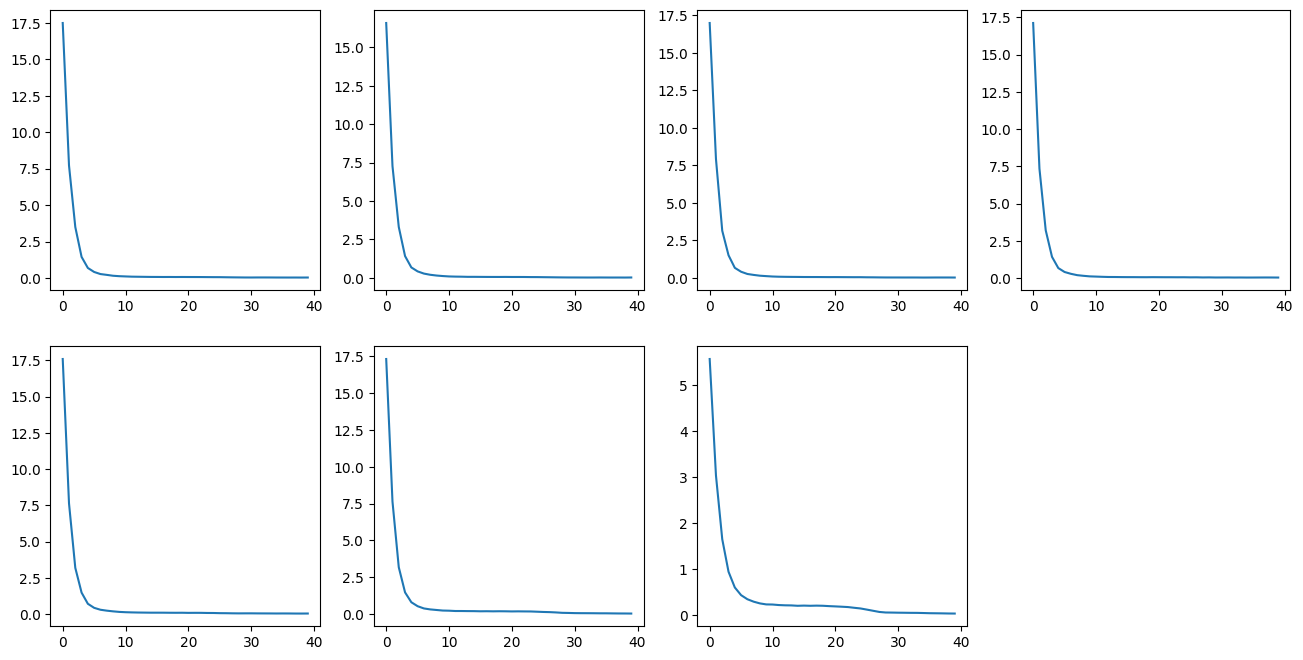

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])
axes.flatten()[-1].axis('off')

(0.0, 1.0, -0.00871493555605412, 0.6797694999724626)

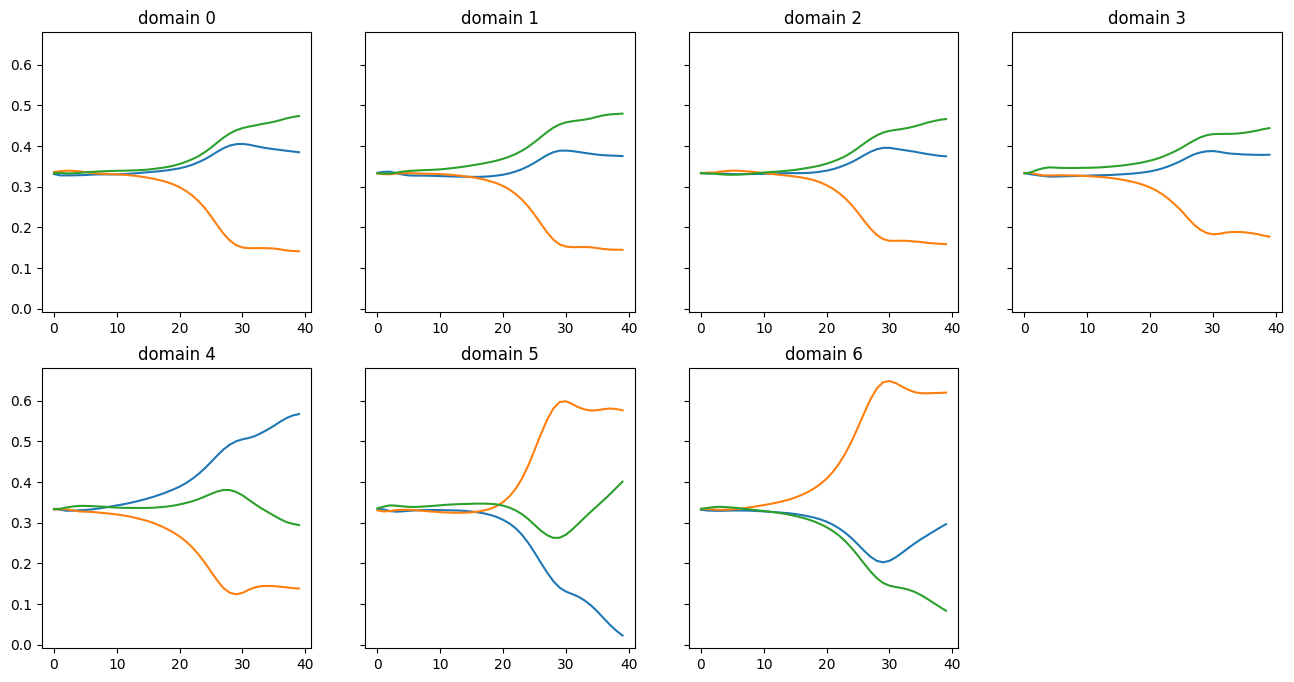

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [18]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.2965, 0.6200, 0.0835])


In [19]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [20]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier()
#clf = KNeighborsClassifier()
#clf = GaussianProcessClassifier()
#clf = DecisionTreeClassifier(criterion='entropy')

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.823076923076923


DaDiL-E

In [21]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()
#clf = KNeighborsClassifier()
#clf = GaussianProcessClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.296999990940094 got 0.23461538461538461
Atom 1 w/ weight 0.6200000047683716 got 0.28846153846153844
Atom 2 w/ weight 0.08399999886751175 got 0.49615384615384617
0.28076923076923077


DaDiL-R

In [23]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier()
#clf = KNeighborsClassifier()
clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.5038461538461538


## Classic Dictionary Learning

In [10]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(
    UnsupervisedDatasetMeasure(
        features=Xt.numpy(),
        batch_size=batch_size,
        device='cpu'
    )
)

In [11]:
criterion = JointWassersteinDistance()

In [12]:
dictionary = LabeledDictionary(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [ ]:
dictionary.fit(Q,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

In [14]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

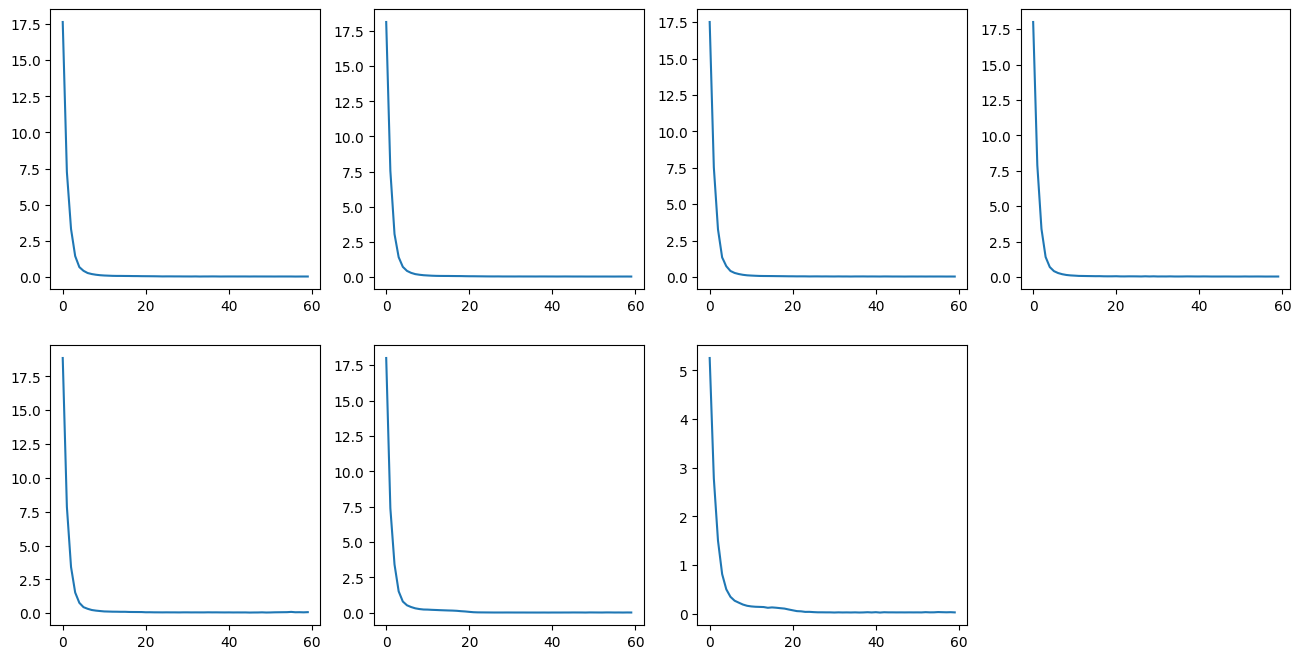

In [15]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])
axes.flatten()[-1].axis('off')

(0.0, 1.0, -0.021898909518495203, 0.628759851725772)

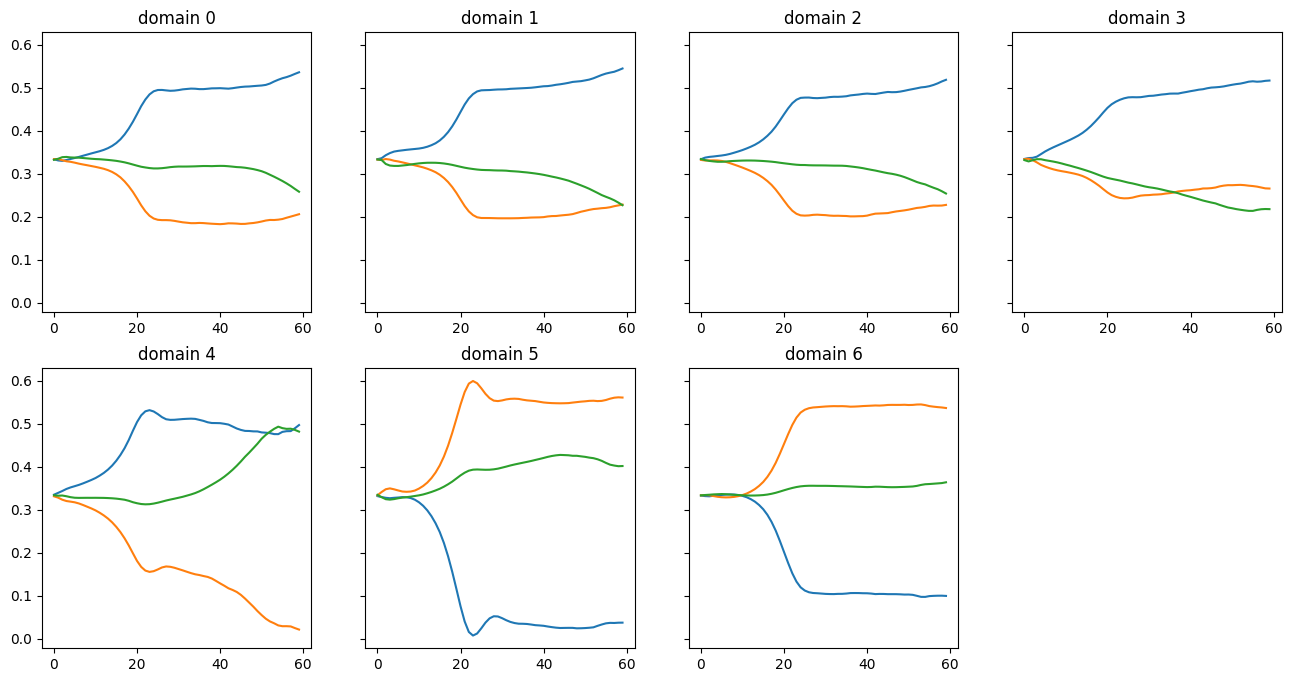

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [17]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.0998, 0.5364, 0.3638])


In [18]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [19]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier()
#clf = KNeighborsClassifier()
#clf = GaussianProcessClassifier()
#clf = DecisionTreeClassifier(criterion='entropy')

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.823076923076923


DaDiL-E

In [51]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()
#clf = KNeighborsClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.10000000149011612 got 0.4346153846153846
Atom 1 w/ weight 0.5360000133514404 got 0.55
Atom 2 w/ weight 0.36399999260902405 got 0.4423076923076923
0.573076923076923


DaDiL-R

In [37]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier(criterion='entropy')
#clf = KNeighborsClassifier()

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.7846153846153846
